In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

## Apple product launch analysis
Loading the data and preprocessing.

In [3]:
df = pd.read_csv("data/quotes-2020-apple-filter.csv",sep=";")
df = df.append(pd.read_csv("data/quotes-2019-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2018-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2017-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2016-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2015-apple-filter.csv",sep=";"))

#List of dates for the apple events
apple_event_dates_str=["2015-03-09","2015-06-10","2015-09-09",
"2016-03-21","2016-06-15","2016-09-07", "2016-10-27",
"2017-06-07", "2017-09-12",
"2018-03-27","2018-06-06", "2018-09-12", "2018-10-30",
"2019-03-25","2019-06-05","2019-09-10","2019-12-02",
"2020-06-24","2020-09-15","2020-10-13","2020-11-10"]

# load sentiment dataframe
sentiment_df = pd.read_csv('./data/sentiment_df.csv')

#apple_event_dates_pd = pd.DataFrame({'Date':[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]})
apple_event_dates=[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]

# Clean the date column, such that it only contains date information and not timestamp
df['date_clean'] = df.apply(lambda x: x['date'][:10],axis=1)
df['date_clean_datetime'] = df['date_clean'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d').date())

# Clean the date column, such that it only contains date information and not timestamp
df['date_clean'] = df.apply(lambda x: x['date'][:10],axis=1)
df['date_clean_datetime'] = df['date_clean'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d').date())
sentiment_df['date_clean_datetime'] = sentiment_df['date_clean'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d').date())


# Drop outlier
df = df.drop(df.loc[df.numOccurrences == 39978].index)

Let's start by looking at how the number of apple related citations are related to product launches.

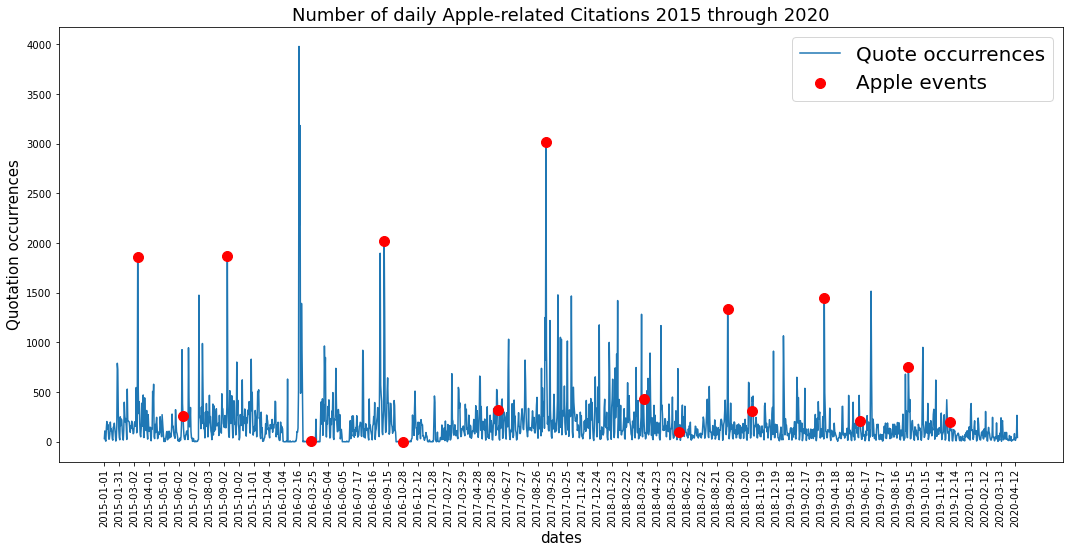

In [4]:
# slice the data frame 
time = df.groupby(['date_clean']).sum().index
quote_num = df.groupby(['date_clean']).sum()['numOccurrences']
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(time,quote_num, label= "Quote occurrences")
ax.set_xlabel("dates",size=15)
ax.scatter(time[time.isin(apple_event_dates_str)],quote_num[time.isin(apple_event_dates_str)], c="r", s=100, zorder=3, label='Apple events')
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=18)
ax.legend(prop={'size': 20})
plt.show()

**Quantifying the media attention**

To quantify the media attention for a given Apple event, the following metrics are formulated:
- **Attention**: The number of weekly quote occurrences.
- **Baseline attention**: Average attention throughout the time period.
- **Event attention**: Avg. of quote occurrences through event week, prior and post week.
- **Event attention increase %**: (Event attention - Baseline attention) / Baseline attention.


To be able to compute these metrics, as well as make further analysis possible, we create the following dataframe:

*Columns:* \
Event-date, attention_week3_pre, attention_week2_pre, attention_week1_pre, attention_week0, attention_week1_post, attention_week2_post, attention_week3_post


In [5]:
df_events = pd.DataFrame()
events = []
for date in apple_event_dates:
    if (date.year == 2019 and date.month < 12) or date.year < 2020:
        events.append(date)
df_events['event_date'] = events

# group data frame by week and year to get weekly attention numbers
df['week'] = df.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[1]), axis=1)
df['year'] = df.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[0]), axis=1)
df['yearweek'] = df['week'] + df['year']
df_attention = df.groupby(['year','week']).sum().reset_index()


# group sentiment data frame
sentiment_df['week'] = sentiment_df.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[1]), axis=1)
sentiment_df['year'] = sentiment_df.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[0]), axis=1)
sentiment_week = sentiment_df.groupby(['year','week']).mean().reset_index()

def attention_query(date, num_weeks):
    "adds weeks to date and returns the attention the corresponding week and year"
    new_date = date + dt.timedelta(weeks=num_weeks)
    year = str(new_date.isocalendar()[0])
    week = str(new_date.isocalendar()[1])
    count = df_attention.loc[(df_attention.week == week) & (df_attention.year == year)].numOccurrences.item()
    return count

def sentiment_query(date, num_weeks):
    "adds weeks to date and returns the sentiment the corresponding week and year"
    new_date = date + dt.timedelta(weeks=num_weeks)
    year = str(new_date.isocalendar()[0])
    week = str(new_date.isocalendar()[1])
    sentiment = sentiment_week.loc[(sentiment_week.week == week) & (sentiment_week.year == year)].compound.item()
    return sentiment

# Create columns for all events
for i in [-3,-2,-1,0,1,2,3]:
    df_events[f"""attention_week{i}{'_pre' if i < 0 else '_post' if i > 0 else ''}"""] = df_events.apply(lambda x: attention_query(x['event_date'], i),axis=1)
    df_events[f"""sentiment_week{i}{'_pre' if i < 0 else '_post' if i > 0 else ''}"""] = df_events.apply(lambda x: sentiment_query(x['event_date'], i),axis=1)

attention_columns =  [ 'attention_week-3_pre', 'attention_week-2_pre',  'attention_week-1_pre', 'attention_week0','attention_week1_post', 'attention_week2_post','attention_week3_post']
sentiment_columns = ['sentiment_week-3_pre','sentiment_week-2_pre','sentiment_week-1_pre','sentiment_week0','sentiment_week1_post','sentiment_week2_post', 'sentiment_week3_post']



Let's visualize the typical distribution of media attention

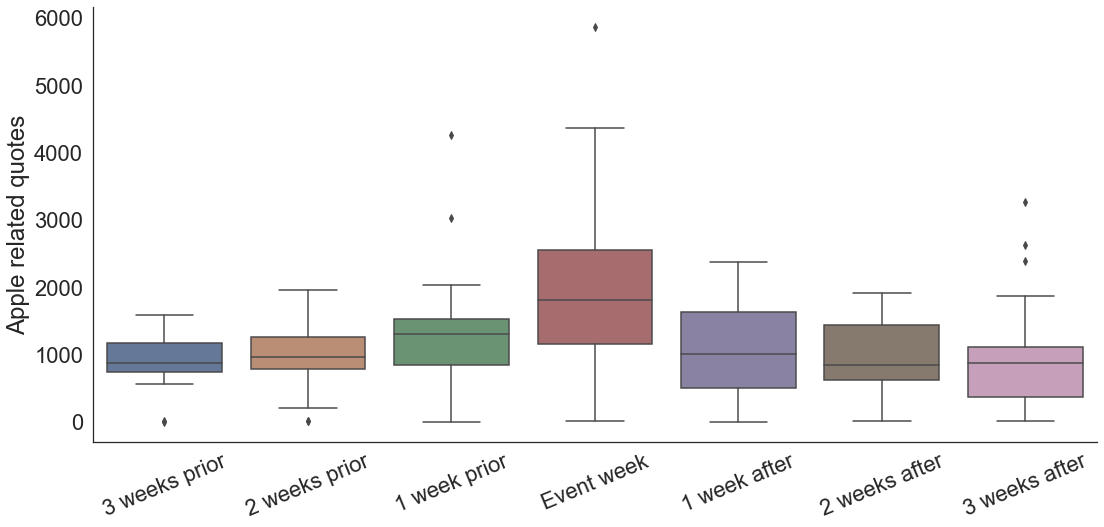

In [24]:
fig,ax = plt.subplots(figsize=(18,8))
sns.set(font_scale=2)
sns.set_theme(style="white", rc={"axes.spines.right": False, "axes.spines.top": False},
              font_scale=2)
ax = sns.boxplot(data=df_events[attention_columns],
                     saturation=0.5)
#ax.set_title("Media attention before, during and after an Apple event")
ax.set_ylabel("Apple related quotes")
positions = (0,1, 2, 3, 4, 5, 6)
labels = ("3 weeks prior", "2 weeks prior", "1 week prior","Event week", "1 week after", "2 weeks after", "3 weeks after")
plt.xticks(positions, labels, rotation=22.5);
#sns.despine(fig)


Looking at the medians, we see that the media attention rises until the week of the event where it peaks and then gradually declines in the following weeks. This shows that Apple is able to build anticipation in the media when launching new products.

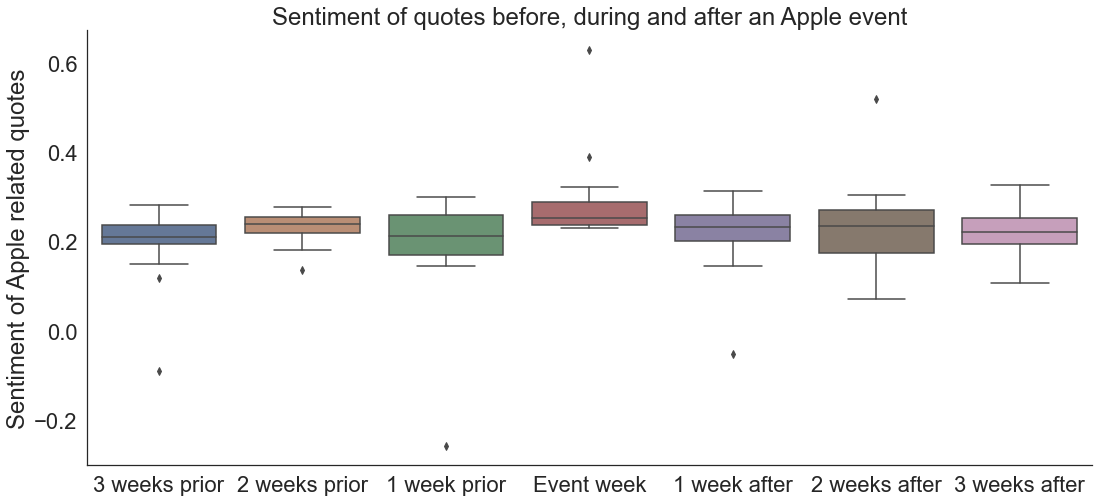

In [7]:
fig,ax = plt.subplots(figsize=(18,8))
ax = sns.boxplot(data=df_events[sentiment_columns],
                     saturation=0.5)
ax.set_title("Sentiment of quotes before, during and after an Apple event")
ax.set_ylabel("Sentiment of Apple related quotes")
positions = (0,1, 2, 3, 4, 5, 6)
labels = ("3 weeks prior", "2 weeks prior", "1 week prior","Event week", "1 week after", "2 weeks after", "3 weeks after")
plt.xticks(positions, labels);

Above we see a boxplot of the average sentiment of the quotes in the weeks prior to and after an apple event. The sentiment value ranges from -1 to 1, with 1 being very positive and -1 being very negative. Across all weeks, we see that the sentiment of the quotes typically lies around 0.2, indicidating a slight positive sentiment in the quotes but mostly neutral. Although the medians do not differ much, the median of the event week is still the highest value. From this we can conclude that Apple generally has a stable reputation in the media, with slightly positive quotes made about them on average.

In [8]:
# Compute baseline
baseline = df_attention.numOccurrences.mean()
df_events['baseline'] = baseline

# Compute average of attention in the weeks prior and after an event 
columns = ['attention_week3_pre', 'attention_week2_pre','attention_week1_pre', 'attention_week0', 'attention_week1_post', 'attention_week2_post', 'attention_week3_post']
df_events['event_attention'] = df_events[columns].mean(axis=1)
df_events['attention_increase'] =  100 * (df_events.event_attention - df_events.baseline) / df_events.baseline
df_events['color'] = df_events.apply(lambda x: 'indianred' if x['attention_increase'] < 0  else 'seagreen',axis=1)
df_events

KeyError: "['attention_week3_pre', 'attention_week2_pre', 'attention_week1_pre'] not in index"

###

Now looking at how different apple events have deviated from the attention average

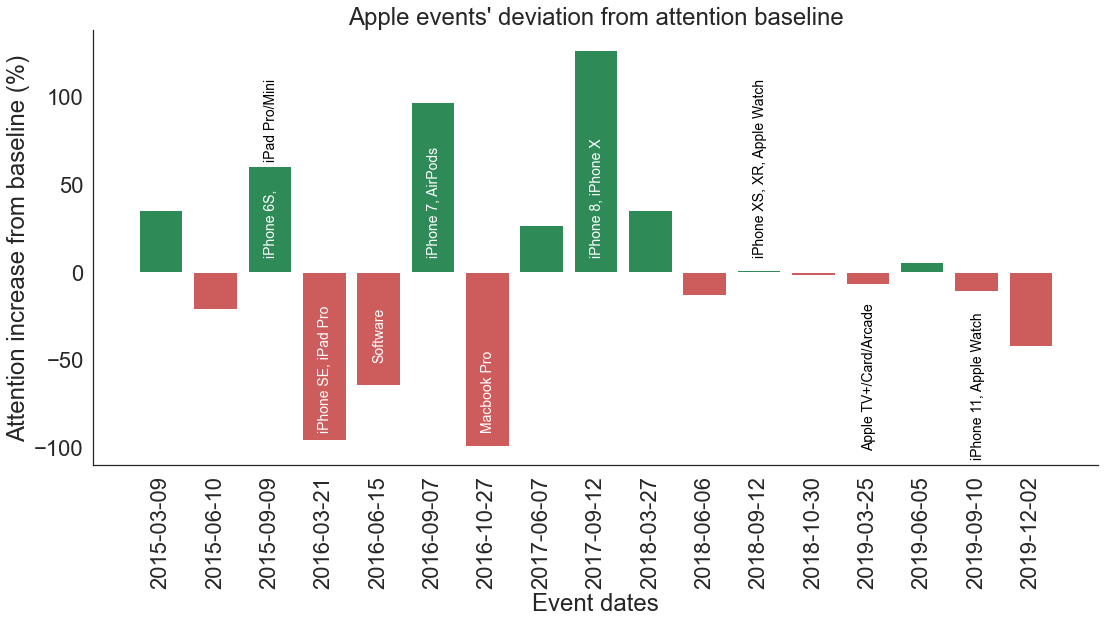

In [ ]:
fig,ax = plt.subplots(figsize=(18,8))
plt.bar(x=apple_event_dates_str[:17],height=df_events.attention_increase,color=df_events.color)
plt.xticks(rotation=90)
plt.xlabel("Event dates")
plt.ylabel("Attention increase from baseline (%)")
plt.title("Apple events' deviation from attention baseline")
plt.text(10.9, 10, "iPhone XS, XR, Apple Watch", fontsize=14,rotation=90,color="black")
plt.text(7.9, 10, "iPhone 8, iPhone X", fontsize=14,rotation=90,color="white")
plt.text(4.9, 10, "iPhone 7, AirPods", fontsize=14,rotation=90,color="white")
plt.text(1.9, 10, "iPhone 6S,", fontsize=14,rotation=90,color="white")
plt.text(1.9, 65, "iPad Pro/Mini", fontsize=14,rotation=90,color="black")
plt.text(5.9, -90, "Macbook Pro", fontsize=14,rotation=90,color="white");
plt.text(2.9, -90, "iPhone SE, iPad Pro", fontsize=14,rotation=90,color="white");
plt.text(3.9, -50, "Software", fontsize=14,rotation=90,color="white");
plt.text(12.9, -100, "Apple TV+/Card/Arcade", fontsize=14,rotation=90,color="black");
plt.text(14.9, -105, "iPhone 11, Apple Watch", fontsize=14,rotation=90,color="black");

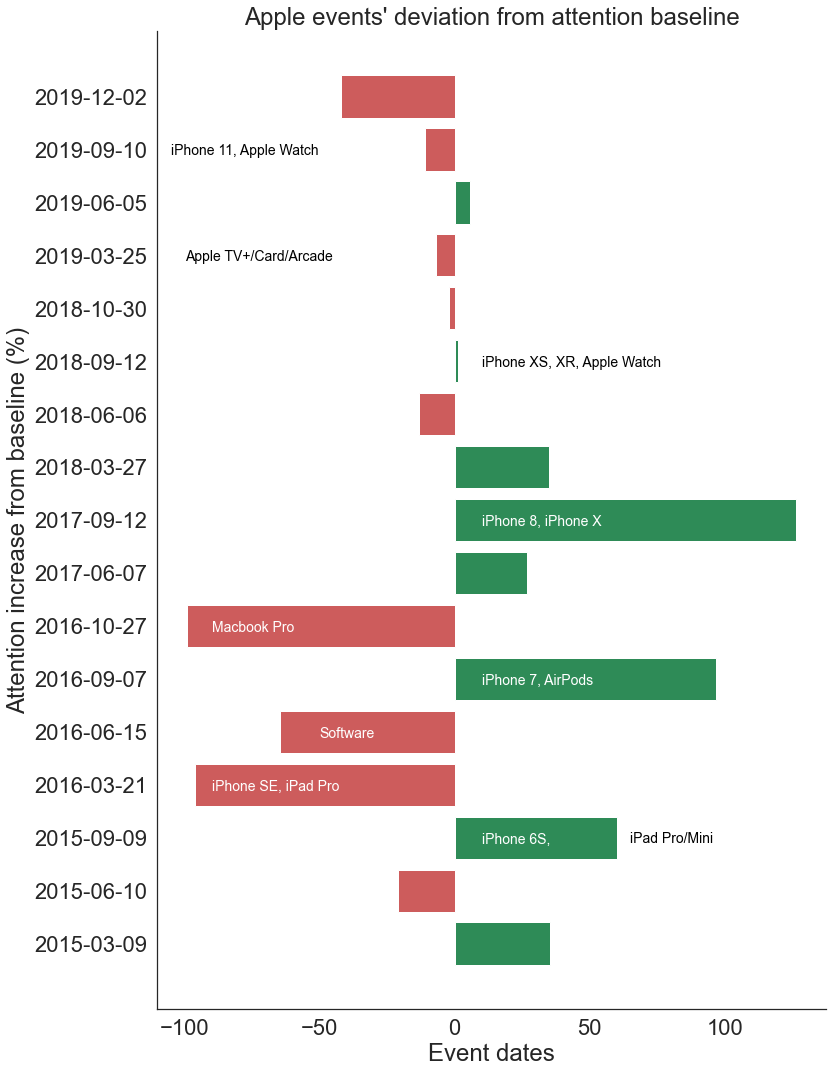

In [ ]:
fig,ax = plt.subplots(figsize=(12,18))
plt.barh(y=apple_event_dates_str[:17],width=df_events.attention_increase,color=df_events.color)
#plt.xticks(rotation=90)
plt.xlabel("Event dates")
plt.ylabel("Attention increase from baseline (%)")
plt.title("Apple events' deviation from attention baseline")
plt.text(10, 10.9, "iPhone XS, XR, Apple Watch", fontsize=14, color="black")
plt.text(10, 7.9, "iPhone 8, iPhone X", fontsize=14,color="white")
plt.text(10, 4.9, "iPhone 7, AirPods", fontsize=14,color="white")
plt.text(10, 1.9, "iPhone 6S,", fontsize=14,color="white")
plt.text(65, 1.9, "iPad Pro/Mini", fontsize=14,color="black")
plt.text(-90, 5.9, "Macbook Pro", fontsize=14,color="white");
plt.text(-90, 2.9, "iPhone SE, iPad Pro", fontsize=14,color="white");
plt.text(-50, 3.9, "Software", fontsize=14,color="white");
plt.text(-100, 12.9, "Apple TV+/Card/Arcade", fontsize=14,color="black");
plt.text(-105, 14.9, "iPhone 11, Apple Watch", fontsize=14,color="black");

## Does the sentiment of quarter earning announcements differ from product launches?

In [ ]:
quarterly_earnings=pd.read_excel('./data/Earnings_Apple.xlsx')

#Remove the unnecessary rows in the quarterly_earnings
quarterly_earnings=quarterly_earnings.drop(index=[0,1,2,3,4,5,6,7])

#Change the format of the Earnings Date column
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: x.replace(", 12 AMEST", "").replace(",", ""))
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: dt.datetime.strptime(x, "%b %d %Y"))

#Clean surprise factor\n",
quarterly_earnings["Surprise(%)"] = quarterly_earnings["Surprise(%)"].map(lambda x: -1*x[1:] if x[0] == '-' else x[1:])

# Remove dates before 2020\n",
to_drop = []
for i, date in enumerate(quarterly_earnings["Earnings Date"]):
    if date.year > 2019:
        to_drop.append(i+8)
quarterly_earnings = quarterly_earnings.drop(index=to_drop,axis=0)

# Add sentiment columns\n",
for i in [-3,-2,-1,0,1,2,3]:
    quarterly_earnings[f"""sentiment_week{i}{'_pre' if i < 0 else '_post' if i > 0 else ''}"""] = quarterly_earnings.apply(lambda x: sentiment_query(x['Earnings Date'], i),axis=1)

Text(0.5, 1.0, 'Comparison of mean sentiment for product launches and earning announcements')

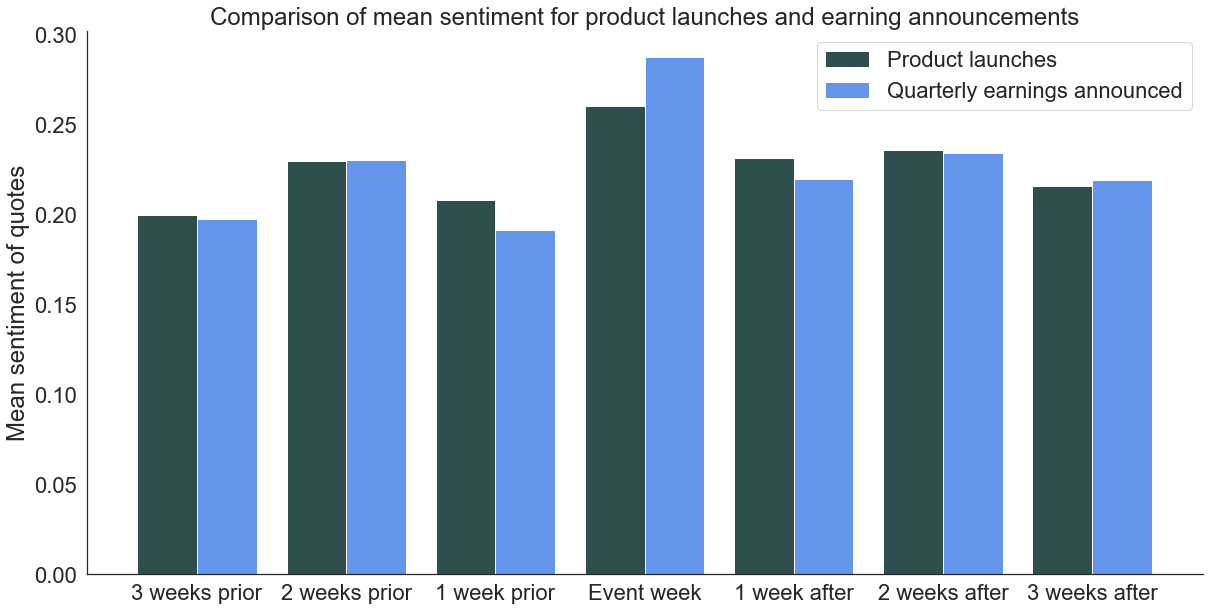

In [ ]:
a = quarterly_earnings[sentiment_columns].mean().tolist()
b = df_events[sentiment_columns].mean().tolist()

# plot data in grouped manner of bar type\n",
plt.subplots(figsize=(20,10))
x = np.arange(7)
width = 0.4
plt.bar(x-0.2, a, width,color='darkslategrey')
plt.bar(x+0.2, b, width,color='cornflowerblue')
plt.xticks(x,labels)
plt.legend(['Product launches', 'Quarterly earnings announced'])
plt.ylabel("Mean sentiment of quotes")
plt.title("Comparison of mean sentiment for product launches and earning announcements")


Looking at the plot above, it can be seen that the sentiment of quotes before and after product launches on average are very similar the sentiment of quotes before and after announcements of quarterly earnings. The quotes are, however, generally more positive in the weeks where quarterly earnings are announced than in the weeks where new products are launched. This can be explained by the fact that quarterly reports typically are described with more adjectives, whereas product launches may be more factual and thus neutral.

### Does the sentiment/attention before and after a product launch correlate with changes in the stock price?

In [26]:
# Calculate sentiment change for each of the product launches
df_events['sentiment_change'] = df_events["sentiment_week1_post"] - df_events['sentiment_week-1_pre']
df_events['attention_change'] = df_events["attention_week1_post"] - df_events['attention_week-1_pre']


# Calculate the change in stock price before and after each stock price (average of the week before to the week after)
stock_data_events=pd.read_csv('./data/AAPL_2015_to_2020_yahoo_finance.csv')
stock_data_events.Date = pd.to_datetime(stock_data_events.Date) - pd.to_timedelta(7, unit='d')
stock_data_events = stock_data_events.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index().sort_values('Date')
stock_data_events['week'] = stock_data_events.apply(lambda x: x['Date'].week,axis=1)
stock_data_events['year'] = stock_data_events.apply(lambda x: x['Date'].year,axis=1)

def stock_query(date):
    "Given date returns the difference between the stockprice the week before and after said date"
    year = date.isocalendar()[0]
    week = date.isocalendar()[1]
    stock_start = stock_data_events.loc[(stock_data_events.week == week - 1) & (stock_data_events.year == year)].Open.item()
    stock_end = stock_data_events.loc[(stock_data_events.week == week + 1) & (stock_data_events.year == year)].Close.item()

    diff = stock_start - stock_end
    return diff


df_events["stock_change"] = df_events.apply(lambda x: stock_query(x['event_date']),axis=1)

Let's see if there is any connection between the change in stock price and sentiment/attention

Text(0.5, 0, 'Change in stock price ($)')

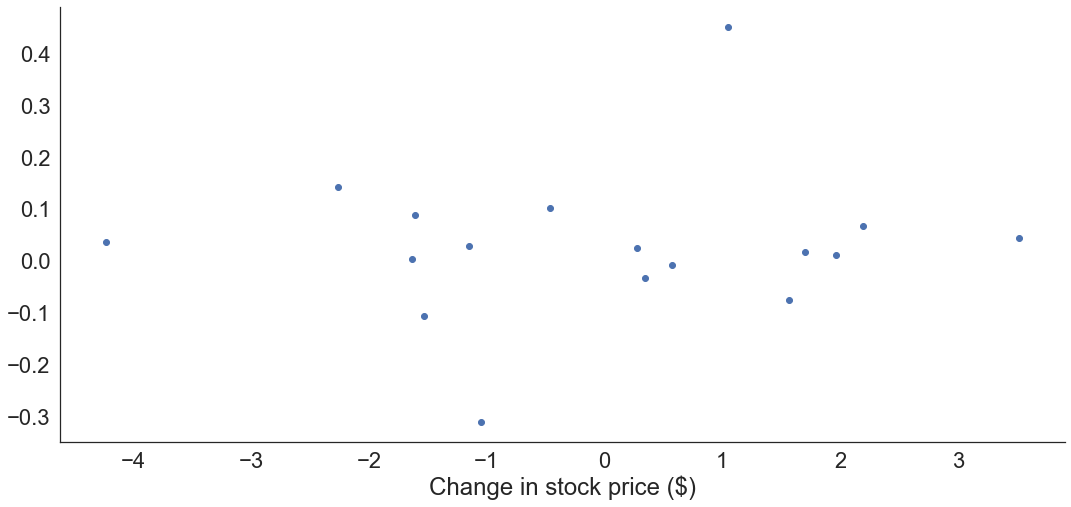

In [30]:
plt.subplots(figsize=(18,8))
plt.scatter(df_events["stock_change"], df_events["sentiment_change"])
plt.xlabel("Change in stock price ($)")
plt.ylabel("Change in stock price ($)")

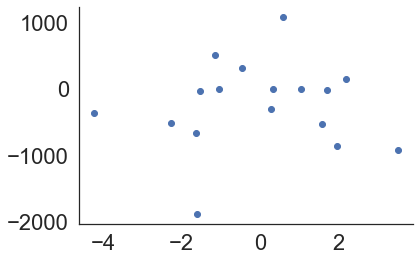

In [31]:
plt.scatter(df_events["stock_change"], df_events["attention_change"])